In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('Hotel Reservations.csv')

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
temp=df[df['arrival_date']==29]
temp=temp[temp['arrival_month']==2]
temp.shape

(37, 19)

In [5]:
list_to_drop= temp.index.tolist()

In [6]:
df.drop(list_to_drop,inplace=True)

In [7]:
df['date'] = pd.to_datetime(df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str))
df['quarter'] = pd.to_datetime(df['date']).dt.quarter

In [8]:
df_thresh=df[['quarter','room_type_reserved','lead_time','avg_price_per_room','booking_status']]

In [9]:
rooms_to_keep = ['Room_Type 1', 'Room_Type 4']
df_thresh_count=df_thresh[df_thresh['room_type_reserved'].isin(rooms_to_keep)]

In [10]:
df_thresh_count_cancelled=df_thresh_count[df_thresh_count['booking_status']=='Canceled']

In [11]:
df_thresh_count_cancelled_90=df_thresh_count_cancelled[df_thresh_count_cancelled['lead_time']>89]
df_thresh_count_cancelled_=df_thresh_count_cancelled[df_thresh_count_cancelled['lead_time']<90]

In [12]:
results = []

for room_type in df_thresh_count_cancelled_90['room_type_reserved'].unique():
    for quarter in df_thresh_count_cancelled_90['quarter'].unique():
        room_type_data = df_thresh_count_cancelled_90[df_thresh_count_cancelled_90['room_type_reserved'] == room_type]
        room_type_data = room_type_data[df_thresh_count_cancelled['quarter'] == quarter]
        ranges = [(90, room_type_data['lead_time'].max())]
        results.extend([(room_type, quarter, f'{start:.2f}-{end:.2f}',f'{start:.2f}', f'{end:.2f}',
                         ((room_type_data['lead_time'] > start) & (room_type_data['lead_time'] <= end)).sum()) 
                        for start, end in ranges])
result_df_90 = pd.DataFrame(results, columns=['Room Type','quarter', 'Range', 'Lead_time_min','Lead_time_max','Count'])
result_df_90= result_df_90.sort_values(['Room Type', 'quarter'])
result_df_90['Weighted_count']=result_df_90['Count']/df_thresh_count_cancelled_90.shape[0]
result_df_90['Lead_time_max'] = pd.to_numeric(result_df_90['Lead_time_max'])
result_df_90['Weighted_lead_time']=result_df_90['Lead_time_max']/result_df_90['Lead_time_max'].sum()

/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/872532923.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  room_type_data = room_type_data[df_thresh_count_cancelled['quarter'] == quarter]


In [14]:
result_df_90['Lead_time_min'] = pd.to_numeric(result_df_90['Lead_time_min']).astype(int)

def calculate_mean_price(row):
    room_type = row['Room Type']
    min_lead_time = row['Lead_time_min']
    max_lead_time = row['Lead_time_max']
    
    filtered_prices = df_thresh_count_cancelled_90[
        (df_thresh_count_cancelled_90['room_type_reserved'] == room_type) &
        (df_thresh_count_cancelled_90['lead_time'] >= min_lead_time) &
        (df_thresh_count_cancelled_90['lead_time'] <= max_lead_time)
    ]
    return filtered_prices['avg_price_per_room'].mean()
df_thresh_count_cancelled_90 = df_thresh_count_cancelled_90.reset_index(drop=True)

result_df_90['mean_price'] = result_df_90.apply(calculate_mean_price, axis=1)
result_df_90['total_price']=result_df_90['mean_price']*result_df_90['Count']
result_df_90['Weighted_price'] = result_df_90['total_price']/result_df_90['total_price'].sum()

In [15]:
results = []

for room_type in df_thresh_count_cancelled['room_type_reserved'].unique():
    for quarter in df_thresh_count_cancelled['quarter'].unique():
        room_type_data = df_thresh_count_cancelled[df_thresh_count_cancelled['room_type_reserved'] == room_type]
        room_type_data = room_type_data[df_thresh_count_cancelled['quarter'] == quarter]
        quartiles = room_type_data['lead_time'].quantile([0.25, 0.75])
        mean_lead_days = room_type_data['lead_time'].mean()
        ranges = [(-1, quartiles[0.25]), (quartiles[0.25], mean_lead_days),(mean_lead_days, quartiles[0.75]),
            (quartiles[0.75], room_type_data['lead_time'].max())]
        results.extend([(room_type, quarter, f'{start:.2f}-{end:.2f}',f'{start:.2f}', f'{end:.2f}',
                         ((room_type_data['lead_time'] > start) & (room_type_data['lead_time'] <= end)).sum()) 
                        for start, end in ranges])
result_df = pd.DataFrame(results, columns=['Room Type','quarter', 'Range', 'Lead_time_min','Lead_time_max','Count'])
result_df['Weighted_count']=result_df['Count']/df_thresh_count_cancelled.shape[0]
result_df['Lead_time_max'] = pd.to_numeric(result_df['Lead_time_max'])
result_df['Weighted_lead_time']=result_df['Lead_time_max']/result_df['Lead_time_max'].sum()

/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3010027521.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  room_type_data = room_type_data[df_thresh_count_cancelled['quarter'] == quarter]
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3010027521.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  room_type_data = room_type_data[df_thresh_count_cancelled['quarter'] == quarter]
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3010027521.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  room_type_data = room_type_data[df_thresh_count_cancelled['quarter'] == quarter]
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3010027521.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  room_type_data = room_type_data[df_thresh_count_cancelled['quarter'] == quarter]
/var/folders/r9/s7zsd2g16z1gx1whz5r9

In [17]:
result_df['Lead_time_min'] = pd.to_numeric(result_df['Lead_time_min']).astype(int)

def calculate_mean_price(row):
    room_type = row['Room Type']
    min_lead_time = row['Lead_time_min']
    max_lead_time = row['Lead_time_max']
    
    filtered_prices = df_thresh_count_cancelled[
        (df_thresh_count_cancelled['room_type_reserved'] == room_type) &
        (df_thresh_count_cancelled['lead_time'] >= min_lead_time) &
        (df_thresh_count_cancelled['lead_time'] <= max_lead_time)
    ]
    return filtered_prices['avg_price_per_room'].mean()
df_thresh_count_cancelled = df_thresh_count_cancelled.reset_index(drop=True)

result_df['mean_price'] = result_df.apply(calculate_mean_price, axis=1)
result_df['total_price']=result_df['mean_price']*result_df['Count']
result_df['Weighted_price'] = result_df['total_price']/result_df['total_price'].sum()

In [45]:
final_df = pd.concat([result_df_90, result_df], ignore_index=True)a = final_df['Weighted_price'] * final_df['total_price']
b = final_df['Weighted_count'] * final_df['Count']
c = final_df['Weighted_lead_time'] * (1 / final_df['Lead_time_max'])
d = final_df['Weighted_count'] + final_df['Weighted_lead_time'] + final_df['Weighted_price']
final_df['total_revenue_calc']= np.where(final_df['Lead_time_min']==90, 0 , round((a+b+c)/d))
final_df['revenue_per_room_calc'] = round(final_df['total_revenue_calc']/final_df['Count'])
final_df['%revenue'] = round((((a+b+c)/d)/final_df['Count']*100)/final_df['mean_price'])

final_df

In [40]:
print('Possible Revenue to be Generated: $', final_df['total_revenue_calc'].sum())
print('Loss Incurred: $' ,final_df['total_price'].sum())
print("We managed to assist the hotel in recovering approximately", str(final_df['total_revenue_calc'].sum()*100
                                                                       /final_df['total_price'].sum()), '%')

Possible Revenue to be Generated: $ 428282.0
Loss Incurred: $ 1928292.7775458856
We managed to assist the hotel in recovering approximately 22.210423903836283 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


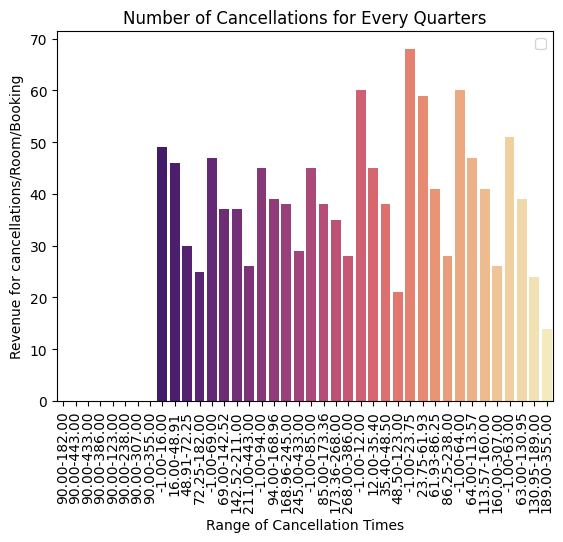

In [41]:
b=sns.barplot(x= 'Range', y='revenue_per_room_calc', data=final_df, palette='magma')
b.set_xticklabels(b.get_xticklabels(),rotation=90)
plt.xlabel('Range of Cancellation Times')
plt.ylabel('Revenue for cancellations/Room/Booking')
plt.title('Number of Cancellations for Every Quarters')
plt.legend()
plt.savefig('Cancellation Policy by Room.png',format='png')

/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3236825711.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x= 'Range', y='total_revenue_calc', data=final_df[final_df['Room Type']=='Room_Type 1'], palette='magma', label='Total Revenue from recommendation')
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3236825711.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x= 'Range', y='total_price', data=final_df[final_df['Room Type']=='Room_Type 1'], palette='magma', label='Total Loss')
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3236825711.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_xticklabels(b.get_xticklabels(),rotation=45, ha="right")


<function matplotlib.pyplot.show(close=None, block=None)>

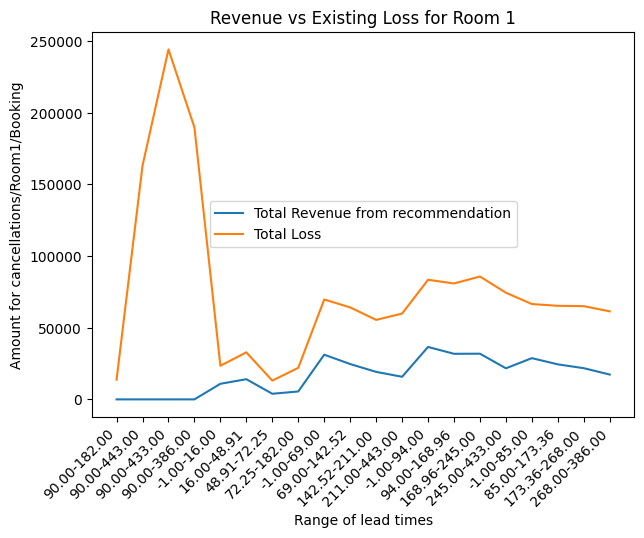

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(style = "whitegrid")
a,b=plt.subplots(figsize=(7,5))

sns.lineplot(x= 'Range', y='total_revenue_calc', data=final_df[final_df['Room Type']=='Room_Type 1'], palette='magma', label='Total Revenue from recommendation')

sns.lineplot(x= 'Range', y='total_price', data=final_df[final_df['Room Type']=='Room_Type 1'], palette='magma', label='Total Loss')

b.set_xticklabels(b.get_xticklabels(),rotation=45, ha="right")
b.set_xlabel('Range of lead times')
b.set_ylabel('Amount for cancellations/Room1/Booking')
b.set_title('Revenue vs Existing Loss for Room 1')

b.legend(loc = "center")

# plt.tight_layout()
plt.savefig('Cancellation Policy by Room1.png',format='png')
plt.show

/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3448917790.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x= 'Range', y='total_revenue_calc', data=final_df[final_df['Room Type']=='Room_Type 4'], palette='magma', label='Total Revenue from recommendation')
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3448917790.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x= 'Range', y='total_price', data=final_df[final_df['Room Type']=='Room_Type 4'], palette='magma', label='Total Loss')
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_94169/3448917790.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_xticklabels(b.get_xticklabels(),rotation=45, ha="right")


<function matplotlib.pyplot.show(close=None, block=None)>

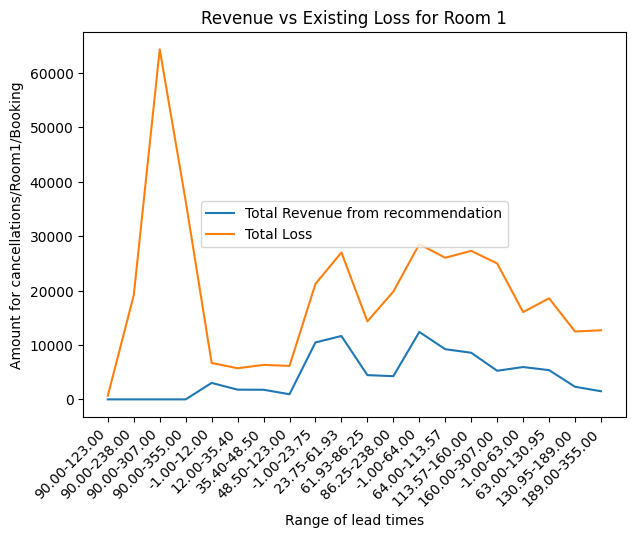

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(style = "whitegrid")
a,b=plt.subplots(figsize=(7,5))

sns.lineplot(x= 'Range', y='total_revenue_calc', data=final_df[final_df['Room Type']=='Room_Type 4'], palette='magma', label='Total Revenue from recommendation')

sns.lineplot(x= 'Range', y='total_price', data=final_df[final_df['Room Type']=='Room_Type 4'], palette='magma', label='Total Loss')

b.set_xticklabels(b.get_xticklabels(),rotation=45, ha="right")
b.set_xlabel('Range of lead times')
b.set_ylabel('Amount for cancellations/Room1/Booking')
b.set_title('Revenue vs Existing Loss for Room 1')

b.legend(loc = "center")

# plt.tight_layout()
plt.savefig('Cancellation Policy by Room1.png',format='png')
plt.show

In [44]:
final_df

,Room Type,quarter,Range,Lead_time_min,Lead_time_max,Count,Weighted_count,Weighted_lead_time,mean_price,total_price,Weighted_price,total_revenue_calc,revenue_per_room_calc,%revenue
0,Room_Type 1,1,90.00-182.00,90,182.00,136,0.019373,0.073774,100.966396,13731.429820,0.018779,0.0,0.0,0.0
1,Room_Type 1,2,90.00-443.00,90,443.00,1620,0.230769,0.179570,100.637669,163033.023820,0.222958,0.0,0.0,0.0
2,Room_Type 1,3,90.00-433.00,90,433.00,2423,0.345157,0.175517,100.768762,244162.709752,0.333907,0.0,0.0,0.0
3,Room_Type 1,4,90.00-386.00,90,386.00,1879,0.267664,0.156465,100.946527,189678.523642,0.259397,0.0,0.0,0.0
4,Room_Type 4,1,90.00-123.00,90,123.00,5,0.000712,0.049858,134.391635,671.958175,0.000919,0.0,0.0,0.0
5,Room_Type 4,2,90.00-238.00,90,238.00,148,0.021083,0.096473,129.384651,19148.928293,0.026187,0.0,0.0,0.0
6,Room_Type 4,3,90.00-307.00,90,307.00,500,0.071225,0.124443,128.693552,64346.775751,0.087998,0.0,0.0,0.0
7,Room_Type 4,4,90.00-355.00,90,355.00,284,0.040456,0.143899,128.365228,36455.724888,0.049855,0.0,0.0,0.0
8,Room_Type 1,1,-1.00-16.00,-1,16.00,221,0.019849,0.003169,106.065378,23440.448571,0.019582,10878.0,49.0,46.0
9,Room_Type 1,1,16.00-48.91,16,48.91,305,0.027394,0.009686,107.558848,32805.448493,0.027405,14071.0,46.0,43.0
